# Corporate Bond Returns Summary

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, "../../src")

import pandas as pd
#import polars as pl

from he_kelly_manela import pull_he_kelly_manela
from bond_returns import pull_open_source_bond , calc_corp_bond_returns
from settings import config

DATA_DIR = Path(config("DATA_DIR"))


---

### 🧹 Data Cleaning — *He, Kelly, and Manella (HKM) follow Nozawa (2017)*

The data cleaning procedure used by **He, Kelly, and Manella** is based on the meticulous framework established in **Nozawa (2017)**. This process ensures consistency, comparability, and robustness in corporate bond return analysis.

---

### 📄 Data Cleaning Summary — *Nozawa (2017)*

Nozawa (2017) constructs a high-quality corporate bond dataset by applying the following key cleaning steps:

#### 🔹 Bond Selection Criteria

* **Exclude bonds** with:

  * **Floating rate coupons**
  * **Non-callable option features** (e.g., puts, convertibles). However, callable bonds are retained due to their prevalence in historical data.
* **Price filters**:

  * Remove observations where the **corporate bond price exceeds** the price of its matched Treasury.
  * Drop observations where price < **\$0.01 per \$1 face value**.
* **Return reversals**:

  * Eliminate both return observations if the **product of adjacent returns is < -0.04**, suggesting a data entry error or extreme correction.

#### 🔹 Data Sources Used

* Combined data from:

  * **Lehman Brothers Fixed Income Database**
  * **Mergent FISD/NAIC Database**
  * **TRACE**
  * **DataStream**
* Defaults are verified and completed using **Moody’s Default Risk Service**.
* **CRSP** and **Compustat** are used to supplement with equity and accounting data.

#### 🔹 Synthetic Treasury Construction

* For each corporate bond, a **synthetic Treasury bond** with an identical cash flow structure is constructed.
* Treasury prices are based on **Federal Reserve constant-maturity yield data**.
* This enables clean computation of **excess returns** and **credit spreads**, expressed in **price terms** rather than yield spreads, to maintain linearity and reduce approximation error.

#### 🔹 Additional Adjustments

* Callable bonds are retained and accounted for using **fixed effects** in regression models (callability has minor pricing impact, \~9 bps).
* The study uses **monthly returns**, avoiding the need for reinvestment assumptions.

---

This rigorous cleaning pipeline underpins Nozawa’s variance decomposition framework, enabling a reliable split of credit spreads into **expected credit loss** and **risk premium** components.

---


In [2]:
hkm = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=DATA_DIR / "he_kelly_manela")
copr_bonds_hkm = hkm.iloc[:,44:54].copy()
copr_bonds_hkm['yyyymm'] = hkm['yyyymm']
copr_bonds_hkm.head()
copr_bonds_hkm.tail()
copr_bonds_hkm.describe()
copr_bonds_hkm.isnull().sum()

US_bonds_11    60
US_bonds_12    60
US_bonds_13    60
US_bonds_14    60
US_bonds_15    60
US_bonds_16    60
US_bonds_17    60
US_bonds_18    60
US_bonds_19    60
US_bonds_20    60
yyyymm          0
dtype: int64

---

### 📊 FTSFA Dataset — Based on TRACE Data from OpenBondAssetPricing.com

The **FTSFA** (Financial Time Series for Fixed-income Analysis) dataset is constructed using the TRACE (Trade Reporting and Compliance Engine) data available at [openbondassetpricing.com](https://openbondassetpricing.com/). This dataset provides a comprehensive collection of corporate bond data, including market microstructure-adjusted prices and returns, as detailed in the [Monthly TRACE Data README](https://openbondassetpricing.com/wp-content/uploads/2024/07/DRR-README.pdf).

---

### 🧹 Data Cleaning and Construction — *Following Nozawa (2017)*

The FTSFA dataset adheres to the rigorous data cleaning methodology established by Nozawa (2017), ensuring high-quality and reliable corporate bond return data. The key cleaning steps are mentioned above.

---

### 🔍 Understanding the TRACE Dataset

The TRACE dataset, as utilized in the FTSFA dataset, is meticulously curated to provide accurate and comprehensive corporate bond data. Key aspects include:

* **Market Microstructure Adjustments**:

  * Implementation of corrections for market microstructure noise (MMN) to enhance the reliability of bond price and return data.

* **Data Filters**:

  * Application of stringent filters to ensure data quality, such as:

    * Inclusion of only U.S.-domiciled firms.
    * Exclusion of private placements, convertible bonds, and bonds with non-standard interest payment structures.
    * Removal of bonds with insufficient outstanding amounts or missing critical information.


By leveraging the TRACE dataset from openbondassetpricing.com, the FTSFA dataset ensures a robust foundation for analyzing corporate bond returns, adhering to established methodologies and incorporating comprehensive data cleaning procedures.

---


In [3]:
corp_bonds_returns = calc_corp_bond_returns.calc_corp_bond_returns()

In [4]:
corp_bonds_returns.describe()

cs_decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,0.002762,0.003620,0.003947,0.004331,0.004454,0.004881,0.005104,0.005151,0.006479,0.006034
std,0.008170,0.011492,0.013385,0.015658,0.017489,0.018722,0.019877,0.021905,0.027144,0.044092
min,-0.030683,-0.031541,-0.042043,-0.051479,-0.058053,-0.063609,-0.078959,-0.092693,-0.125238,-0.235741
25%,-0.000535,-0.001472,-0.001730,-0.003511,-0.004021,-0.004701,-0.004180,-0.005391,-0.002973,-0.006787
50%,0.002521,0.003326,0.003868,0.004904,0.005555,0.005963,0.007335,0.006837,0.007429,0.007058
75%,0.005154,0.007841,0.010535,0.012265,0.013910,0.014322,0.015455,0.015379,0.015762,0.019912
max,0.069501,0.092004,0.095010,0.088436,0.067761,0.061528,0.066032,0.080626,0.145308,0.214975


---

### 🧮 How Returns Are Computed

For each decile, the **monthly return** is computed as a **value-weighted average of bond-level returns**:

$$
r_{portfolio, t} = \sum_{i \in \text{portfolio}} w_{i,t} \cdot \text{bond\_ret}_{i,t}
$$

where:

* `bond_ret` is the **monthly return** of an individual bond.
* $w_{i,t} = \frac{\text{bond value}_{i,t}}{\sum_{j \in \text{portfolio}} \text{bond value}_{j,t}}$ is the **weight** of bond $i$ in the portfolio at time $t$.
* `bond value` is calculated as the product of the **MMN-adjusted clean price** and **amount outstanding**.

This weighting ensures that larger bonds have a proportionally larger impact on the portfolio return.


### Comparing FTSFA with He Kelly Manela 

HKM Corporate Bonds shape: (516, 11)
Corporate Bond Returns shape: (242, 10)

HKM Corporate Bonds date range: 1970-01-31 00:00:00 to 2012-12-31 00:00:00
Corporate Bond Returns date range: 2002-08-31 00:00:00 to 2022-09-30 00:00:00


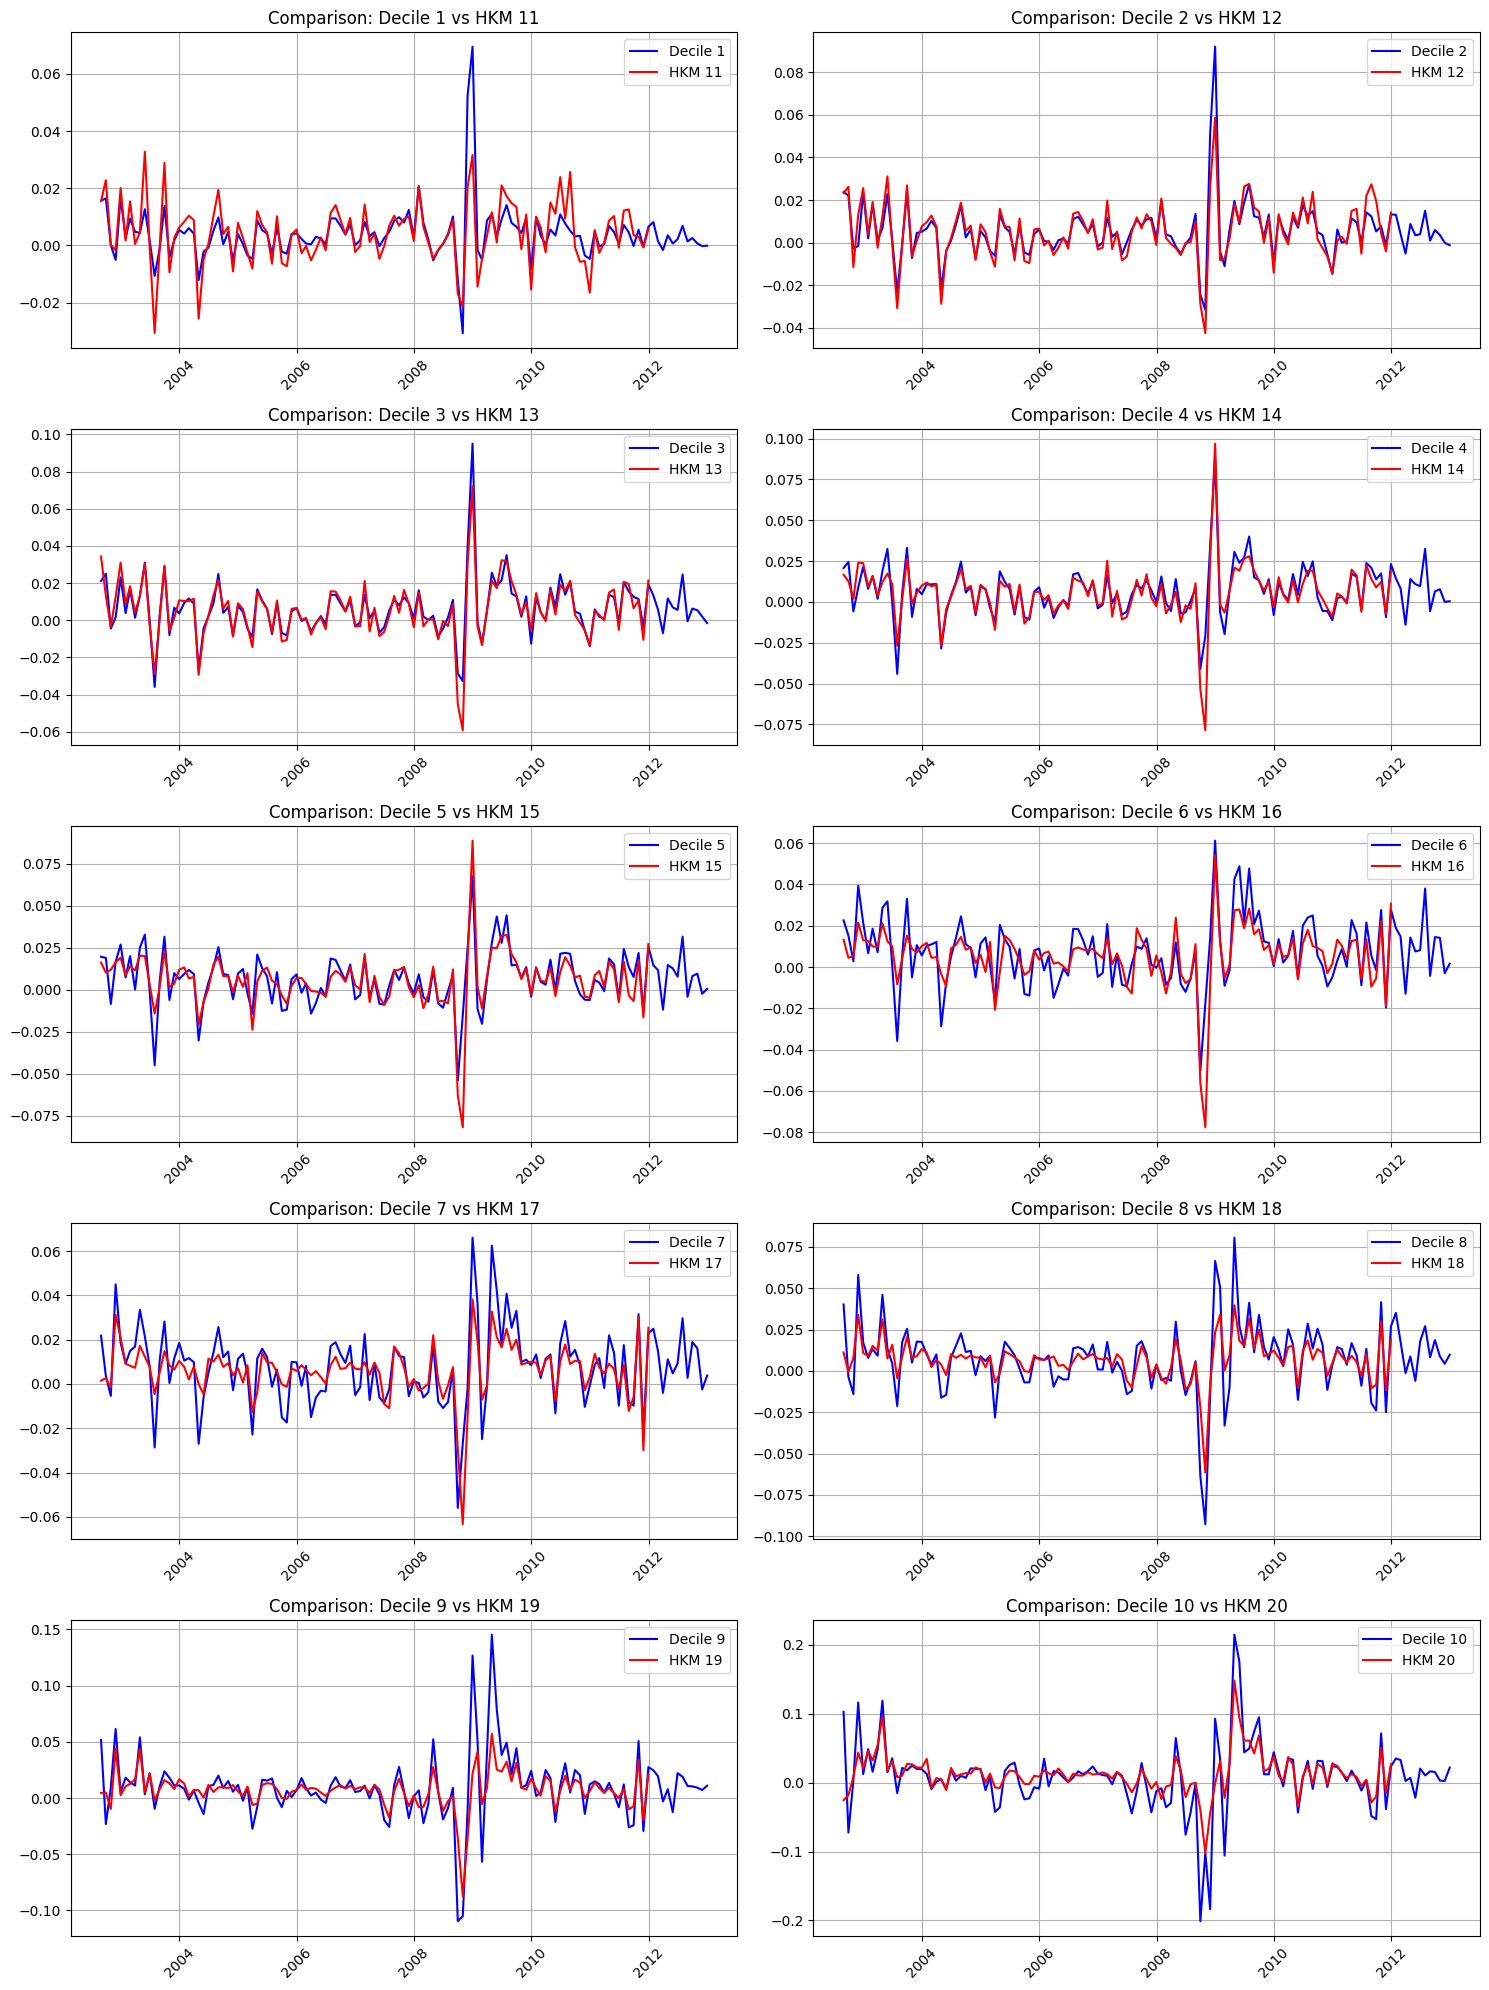


Correlations between corresponding columns:
Decile 1 vs HKM 11: 0.7509
Decile 2 vs HKM 12: 0.9093
Decile 3 vs HKM 13: 0.9414
Decile 4 vs HKM 14: 0.8942
Decile 5 vs HKM 15: 0.8217
Decile 6 vs HKM 16: 0.7661
Decile 7 vs HKM 17: 0.8151
Decile 8 vs HKM 18: 0.9147
Decile 9 vs HKM 19: 0.8412
Decile 10 vs HKM 20: 0.8313


In [5]:
# Convert yyyymm to datetime (last day of each month)
copr_bonds_hkm['date'] = pd.to_datetime(copr_bonds_hkm['yyyymm'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
copr_bonds_hkm.set_index('date', inplace=True)

# Now both DataFrames have datetime index with last day of month
print("HKM Corporate Bonds shape:", copr_bonds_hkm.shape)
print("Corporate Bond Returns shape:", corp_bonds_returns.shape)

# Display the date ranges to verify alignment
print("\nHKM Corporate Bonds date range:", copr_bonds_hkm.index.min(), "to", copr_bonds_hkm.index.max())
print("Corporate Bond Returns date range:", corp_bonds_returns.index.min(), "to", corp_bonds_returns.index.max())

# Merge the dataframes
merged_df = pd.merge(corp_bonds_returns, copr_bonds_hkm, left_index=True, right_index=True, how='inner')

# Create subplots for each pair of columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(10):
    col1 = i + 1  # Column from corp_bonds_returns
    col2 = f"US_bonds_{i+11}"  # Column from copr_bonds_hkm
    
    ax = axes[i]
    ax.plot(merged_df.index, merged_df[col1], label=f'Decile {i+1}', color='blue')
    ax.plot(merged_df.index, merged_df[col2], label=f'HKM {i+11}', color='red')
    ax.set_title(f'Comparison: Decile {i+1} vs HKM {i+11}')
    ax.legend()
    ax.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print correlation between corresponding columns
print("\nCorrelations between corresponding columns:")
for i in range(10):
    col1 = i + 1
    col2 = f"US_bonds_{i+11}"
    corr = merged_df[col1].corr(merged_df[col2])
    print(f"Decile {i+1} vs HKM {i+11}: {corr:.4f}")

---

### 📈 Comparison of Corporate Bond Portfolio Returns: FTSFA Deciles vs. HKM Portfolios

The figure above compares the time-series returns of corporate bond portfolios:

* **Deciles 1–10** (in blue): Portfolios constructed by **FTSFA**, where bonds are sorted into deciles based on a chosen signal.
* **HKM Portfolios 11–20** (in red): Portfolios from **He, Kelly, and Manella (HKM)** that correspond to the same strategy but are indexed from 11 to 20.



The HKM portfolios are indexed from **11 to 20**, with portfolio 11 corresponding to the lowest decile (Decile 1) and portfolio 20 corresponding to the highest (Decile 10). Therefore, the matching scheme is:

* **Decile 1 → HKM 11**
* **Decile 2 → HKM 12**
* …
* **Decile 5 → HKM 15**
* …
* **Decile 10 → HKM 20**

---

### 🔍 Observations

* The plotted returns between **FTSFA deciles (blue)** and **HKM portfolios (red)** are **visibly similar**, indicating that both datasets reflect consistent underlying return dynamics.
* Particularly during volatile periods like the **2008 financial crisis**, both series exhibit synchronized spikes or drops, reflecting shared exposure to credit market risk.
* Deviations are expected due to:

  * Variation in data sources and MMN adjustments.
  * Differences in exact sorting filters.

---

These comparisons validate that the FTSFA replication accurately captures the structure and behavior of the HKM portfolio.
